In [3]:
import glob
import os
import warnings

import librosa
import librosa.display
import matplotlib.pylab as plt
import numpy as np

warnings.filterwarnings('ignore')

from utils import FMA_RAW, DATA_FOLDER, compute_mfcc, load_tracks

# Classes Distribution

In [4]:
tracks = load_tracks(DATA_FOLDER)

training = tracks['set', 'split'] == "training"
sm_tracks = tracks.loc[tracks['set', 'subset'] <= 'small']
md_tracks = tracks.loc[tracks['set', 'subset'] <= 'medium']

sm_values, sm_counts = np.unique(sm_tracks.loc[training]['track', 'genre_top'], return_counts=True)
md_values, md_counts = np.unique(md_tracks.loc[training]['track', 'genre_top'], return_counts=True)

sorted_idx = np.argsort(md_counts)

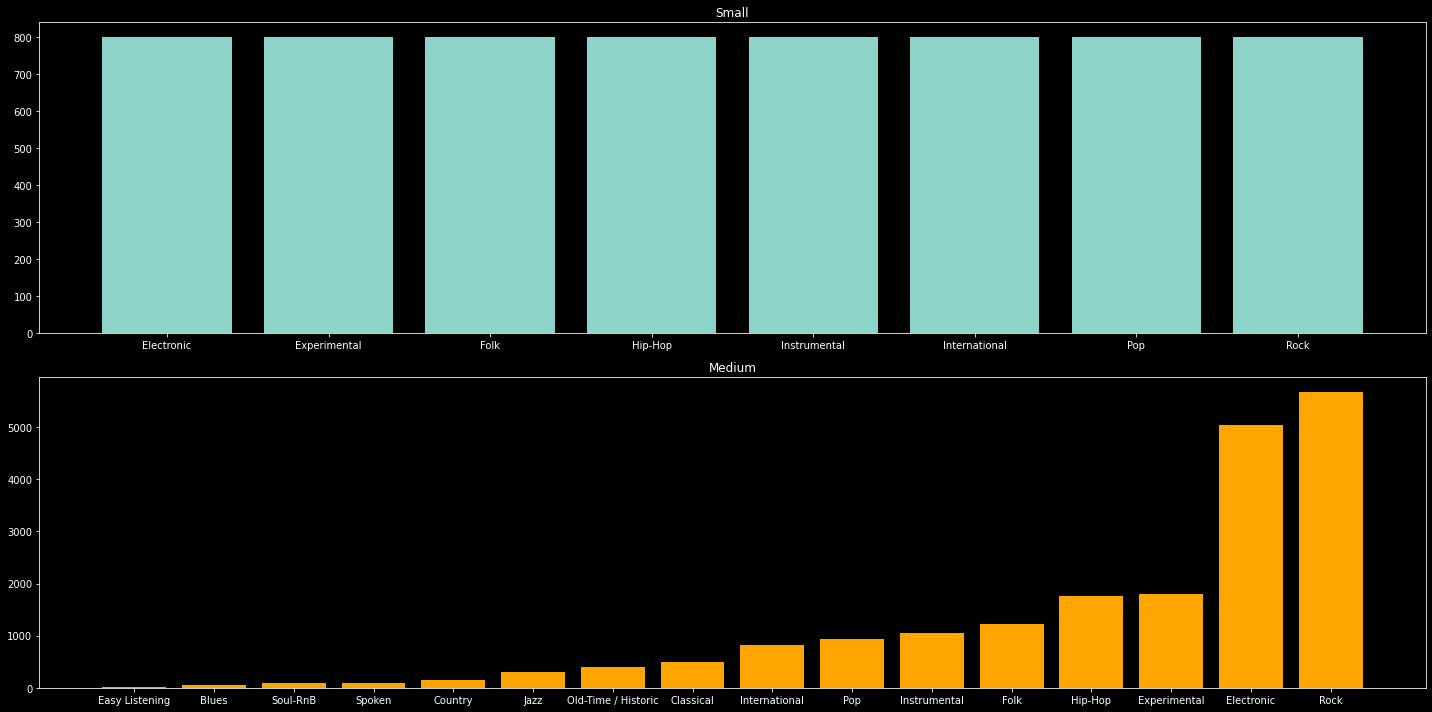

In [5]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 10))
ax1.bar(sm_values, sm_counts)
ax1.set_title("Small")
ax2.bar(md_values[sorted_idx], md_counts[sorted_idx], color='orange')
ax2.set_title("Medium")
fig.tight_layout()

In [6]:
# dataset split percentages
print("[Small]")
print(sm_tracks['set', 'split'].value_counts(normalize=True))

print("\n[Medium]")
print(md_tracks['set', 'split'].value_counts(normalize=True))

[Small]
training      0.8
validation    0.1
test          0.1
Name: (set, split), dtype: float64

[Medium]
training      0.79688
test          0.10292
validation    0.10020
Name: (set, split), dtype: float64


# RAW audio analysis

In [7]:
files = glob.glob(os.path.join(FMA_RAW, "**/*.mp3"), recursive=True)

In [ ]:
examples = [
    {"filename": files[0], "genre": "International"},
    {"filename": files[1], "genre": "Hip-Hop"},
    {"filename": files[4], "genre": "Electronic"},
    {"filename": files[5], "genre": "Experimental"},
    {"filename": files[6], "genre": "Folk"},
    {"filename": files[4386], "genre": "Instrumental"},
    {"filename": files[4792], "genre": "Pop"},
    {"filename": files[4744], "genre": "Rock"}
]

In [ ]:
def plot_signal(filepath, seconds=10, title=None):
    y, sr = librosa.load(filepath, sr=None, mono=True)

    y = y[:sr * seconds]

    fft = np.abs(np.fft.fft(y))
    stft = librosa.stft(y, hop_length=512)
    mel = librosa.feature.melspectrogram(sr=sr, S=np.abs(stft) ** 2)
    stft_log = librosa.amplitude_to_db(np.abs(stft))
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=13)

    fig, axes = plt.subplots(5, 1, figsize=(24, 12))

    librosa.display.waveshow(y, sr=sr, ax=axes[0], x_axis="time")
    axes[1].plot(np.linspace(0, sr, len(fft))[:int(len(fft) / 2)], fft[:int(len(fft) / 2)])
    librosa.display.specshow(stft_log, sr=sr, ax=axes[2], x_axis="time", y_axis="log")
    librosa.display.specshow(mel, sr=sr, ax=axes[3], x_axis="time", y_axis="mel")
    librosa.display.specshow(mfcc, sr=sr, ax=axes[4], x_axis="time")

    axes[0].margins(0)
    axes[1].margins(0)

    axes[0].set_ylabel("Amplitude")
    axes[1].set_ylabel("Magnitude")
    axes[1].set_xlabel("Hz")
    axes[4].set_ylabel("MFCC")

    fig.suptitle(title)
    fig.tight_layout()
    fig.show()

for e in examples:
    plot_signal(e["filename"], title=e["genre"])

In [ ]:
fig1, axes1 = plt.subplots(4, 4, figsize=(24, 10))
fig2, axes2 = plt.subplots(4, 4, figsize=(24, 10))
fig3, axes3 = plt.subplots(4, 4, figsize=(24, 10))

for i in range(4):
    for j in range(4):
        e = examples[i * 4 + j]
        mfcc, mfcc_d, mfcc_dd = compute_mfcc(e["filename"], duration=29.97, concatenate=False)

        librosa.display.specshow(mfcc, ax=axes1[i, j], sr=44100)
        librosa.display.specshow(mfcc_d, ax=axes2[i, j], sr=44100)
        librosa.display.specshow(mfcc_dd, ax=axes3[i, j], sr=44100)

        axes1[i, j].set_title(e["genre"])
        axes2[i, j].set_title(e["genre"])
        axes3[i, j].set_title(e["genre"])

fig1.suptitle("MFCC")
fig2.suptitle(r"$\Delta$MFCC")
fig3.suptitle(r"$\Delta\Delta$MFCC")

fig1.tight_layout()
fig2.tight_layout()
fig3.tight_layout()

# Check for Bad Samples

In [ ]:
import pandas as pd
from multiprocessing import Pool

from bad_samples import get_ignore_list
from utils import OUTPUT_FOLDER, SUBSET

for f in get_ignore_list(SUBSET):
    f = os.path.join(FMA_RAW, SUBSET, f)
    if f in files:
        files.remove(f)


def get_infos(filepath):
    y, sr = librosa.load(filepath, sr=None, mono=True)
    return sr, librosa.get_duration(y, sr=sr)


# get durations and sample rates

durations = []
sample_rates = []

nb_workers = int(1.5 * len(os.sched_getaffinity(0)))
with Pool(processes=nb_workers) as pool:
    for i, (sr, d) in enumerate(pool.imap(get_infos, files, chunksize=500)):
        durations.append(d)
        sample_rates.append(sr)

        try:
            if i % 500 == 0:
                print(i, (sr, d))
        except Exception:
            pass

                  0
count   7994.000000
mean   44261.896422
std     1267.865876
min    22050.000000
25%    44100.000000
50%    44100.000000
75%    44100.000000
max    48000.000000


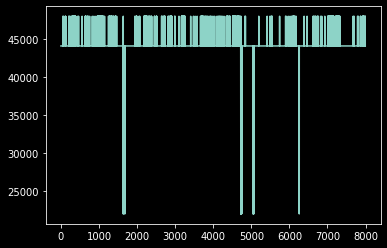

In [13]:
plt.plot(sample_rates)

sample_rates = np.array(sample_rates)
sample_rates = pd.DataFrame(sample_rates)
indexes = sample_rates.loc[sample_rates[0] != 44100].index

bad_files = list(np.array(files)[indexes])
np.save(os.path.join(OUTPUT_FOLDER, "bad_samples_files"), bad_files)
print(sample_rates.describe())

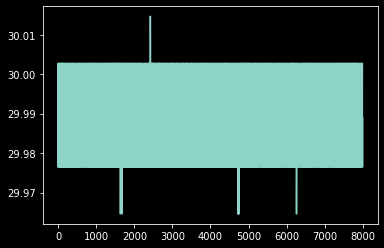

                 0
count  7994.000000
mean     29.988161
std       0.012652
min      29.964580
25%      29.976576
50%      29.976576
75%      30.002698
max      30.014694


In [14]:
plt.plot(durations)
plt.show()

durations = np.array(durations)
durations = pd.DataFrame(durations)

print(durations.describe())

In [15]:
print(sum(durations[0] <= 30))
print(sum(durations[0] >  30))
print(sum(durations[0] <= 29.95))

4644
3350
0
